# Nitrogen nutritional index

Soil chemical properties based on LUCAS topsoil data (Ballabio et al., 2019;
European Commission, n.d.; Panagos et al., 2022; Panagos et al., 2012):
https://esdac.jrc.ec.europa.eu/content/chemical-properties-european-scale-based-lucas-topsoil-data

In [1]:
import os
from zipfile import BadZipFile, ZipFile
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rxr
from rasterstats import zonal_stats

In [2]:
DATA_DIR = os.path.join(
    "data",
    "soil",
    "chemical-properties-european-scale-based-lucas-topsoil-data",
)

In [3]:
ZIP_FILE = os.path.join(DATA_DIR, "N.zip")

In [4]:
# list of files/folders in the ZIP archive
ZipFile(ZIP_FILE).namelist()

['N.tfw', 'N.tif', 'N.tif.aux.xml', 'N.tif.xml']

In [5]:
# extract the archive
try:
    z = ZipFile(ZIP_FILE)
    z.extractall(DATA_DIR)
except BadZipFile:
    print("There were issues with the file", ZIP_FILE)

In [6]:
DATA_FILE = os.path.join(DATA_DIR, "N.tif")

In [7]:
data = rxr.open_rasterio(DATA_FILE, chunks="auto", masked=True)

In [8]:
data

<xarray.DataArray (band: 1, y: 8073, x: 7781)>
dask.array<open_rasterio-2dfaadd156014808d6d419048f02a238<this-array>, shape=(1, 8073, 7781), dtype=float32, chunksize=(1, 5760, 5760), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.636e+06 2.636e+06 ... 6.525e+06 6.526e+06
  * y            (y) float64 5.422e+06 5.421e+06 ... 1.386e+06 1.386e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  0.9927304438511346
    STATISTICS_MAXIMUM:      15.40726184845
    STATISTICS_MEAN:         2.1118209123088
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0.99635859199945
    scale_factor:            1.0
    add_offset:              0.0

In [9]:
data.rio.crs

CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]')

In [10]:
data.rio.resolution()

(500.00000000000006, -500.0)

In [11]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries_all.gpkg")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")

In [12]:
ie.crs

<Derived Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
# clip raster to Ireland's boundary
data = rxr.open_rasterio(DATA_FILE, chunks="auto", masked=True).rio.clip(
    ie.buffer(6500).to_crs(data.rio.crs)
)

In [14]:
data

<xarray.DataArray (band: 1, y: 818, x: 835)>
dask.array<getitem, shape=(1, 818, 835), dtype=float32, chunksize=(1, 818, 835), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.918e+06 2.919e+06 ... 3.335e+06 3.335e+06
  * y            (y) float64 3.728e+06 3.728e+06 3.727e+06 ... 3.32e+06 3.32e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  0.9927304438511346
    STATISTICS_MAXIMUM:      15.40726184845
    STATISTICS_MEAN:         2.1118209123088
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0.99635859199945
    scale_factor:            1.0
    add_offset:              0.0

In [15]:
data.max().values

array(9.951199, dtype=float32)

In [16]:
data.min().values

array(1.2719605, dtype=float32)

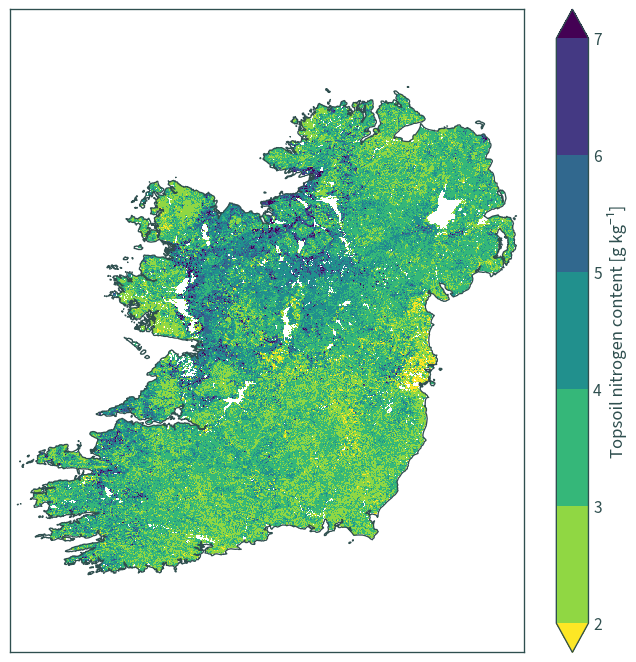

In [17]:
fig = data.plot(
    robust=True,
    cmap="viridis_r",
    figsize=(7, 7),
    levels=6,
    cbar_kwargs={"label": "Topsoil nitrogen content [g kg⁻¹]"},
)
ie.to_crs(data.rio.crs).boundary.plot(
    ax=fig.axes, color="darkslategrey", linewidth=1
)
plt.title(None)
fig.axes.tick_params(labelbottom=False, labelleft=False)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.axis("equal")
plt.show()

In [18]:
# export to GeoTIFF
data.rio.to_raster(os.path.join(DATA_DIR, "IE_N.tif"))

## Grid cells

In [19]:
grid_cells = gpd.read_file(
    os.path.join("data", "ModVege", "params.gpkg"), layer="eurocordex"
)

In [20]:
grid_cells.head()

,rlon,rlat,sr,geometry
0,-17.265,4.345,0.763591,"POLYGON ((419870.326 550490.054, 415715.725 56..."
1,-17.265,4.455,0.000000,"POLYGON ((415715.725 562009.785, 411561.600 57..."
2,-17.265,4.565,0.000000,"POLYGON ((411561.600 573530.159, 407407.964 58..."
3,-17.265,4.675,0.000000,"POLYGON ((407407.964 585051.187, 403254.829 59..."
4,-17.265,4.785,0.000000,"POLYGON ((403254.829 596572.878, 399102.207 60..."


In [21]:
grid_cells.crs

<Derived Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [22]:
grid_cells.shape

(765, 4)

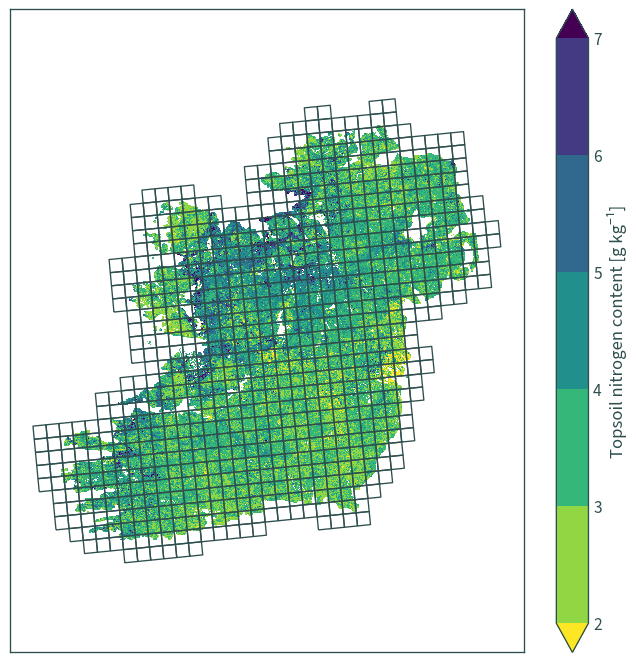

In [23]:
fig = data.plot(
    robust=True,
    cmap="viridis_r",
    figsize=(7, 7),
    levels=6,
    cbar_kwargs={"label": "Topsoil nitrogen content [g kg⁻¹]"},
)
grid_cells.to_crs(data.rio.crs).boundary.plot(
    ax=fig.axes, color="darkslategrey", linewidth=1
)
plt.title(None)
fig.axes.tick_params(labelbottom=False, labelleft=False)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.axis("equal")
plt.show()

## Zonal stats

In [24]:
grid_cells = gpd.GeoDataFrame.from_features(
    zonal_stats(
        vectors=grid_cells.to_crs(data.rio.crs),
        raster=os.path.join(DATA_DIR, "IE_N.tif"),
        stats=["count", "mean"],
        geojson_out=True,
    ),
    crs=data.rio.crs,
).to_crs(grid_cells.crs)

In [25]:
grid_cells.head()

,geometry,rlon,rlat,sr,count,mean
0,"POLYGON ((419870.326 550490.053, 415715.725 56...",-17.265,4.345,0.763591,0,NaN
1,"POLYGON ((415715.725 562009.784, 411561.600 57...",-17.265,4.455,0.000000,0,NaN
2,"POLYGON ((411561.600 573530.159, 407407.964 58...",-17.265,4.565,0.000000,0,NaN
3,"POLYGON ((407407.964 585051.187, 403254.829 59...",-17.265,4.675,0.000000,0,NaN
4,"POLYGON ((403254.829 596572.878, 399102.207 60...",-17.265,4.785,0.000000,0,NaN


In [26]:
grid_cells.shape

(765, 6)

In [27]:
grid_cells["mean"].min()

2.252015869140625

In [28]:
grid_cells["mean"].max()

5.643146769205729

In [29]:
grid_cells["count"].min()

0

In [30]:
grid_cells["count"].max()

604

In [31]:
grid_cells[grid_cells["count"] == 0]

,geometry,rlon,rlat,sr,count,mean
0,"POLYGON ((419870.326 550490.053, 415715.725 56...",-17.265,4.345,0.763591,0,NaN
1,"POLYGON ((415715.725 562009.784, 411561.600 57...",-17.265,4.455,0.000000,0,NaN
2,"POLYGON ((411561.600 573530.159, 407407.964 58...",-17.265,4.565,0.000000,0,NaN
3,"POLYGON ((407407.964 585051.187, 403254.829 59...",-17.265,4.675,0.000000,0,NaN
4,"POLYGON ((403254.829 596572.878, 399102.207 60...",-17.265,4.785,0.000000,0,NaN
...,...,...,...,...,...,...
757,"POLYGON ((767701.819 845561.398, 763481.201 85...",-13.415,5.775,2.524159,0,NaN
761,"POLYGON ((750816.330 891555.630, 746593.742 90...",-13.415,6.215,0.000000,0,NaN
762,"POLYGON ((746593.742 903053.784, 742370.691 91...",-13.415,6.325,0.000000,0,NaN
763,"POLYGON ((770723.258 872751.278, 766498.992 88...",-13.305,5.995,0.000000,0,NaN


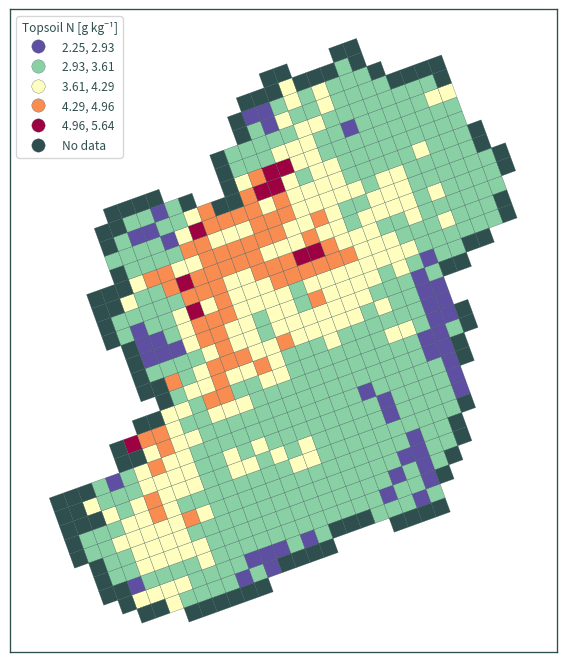

In [32]:
axs = grid_cells.plot(
    column="mean",
    cmap="Spectral_r",
    scheme="equal_interval",
    edgecolor="darkslategrey",
    linewidth=0.2,
    figsize=(6, 7),
    legend=True,
    legend_kwds={
        "loc": "upper left",
        "fmt": "{:.2f}",
        "title": "Topsoil N [g kg⁻¹]",
    },
    missing_kwds={
        "color": "darkslategrey",
        "edgecolor": "darkslategrey",
        "label": "No data",
    },
)
for legend_handle in axs.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(0.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

## Normalise

In [33]:
# normalise between 1.0 and 0.35
grid_cells["ni"] = 0.35 + (
    (grid_cells["mean"] - float(grid_cells["mean"].min())) * (1.0 - 0.35)
) / (float(grid_cells["mean"].max()) - float(grid_cells["mean"].min()))

In [34]:
grid_cells.head()

,geometry,rlon,rlat,sr,count,mean,ni
0,"POLYGON ((419870.326 550490.053, 415715.725 56...",-17.265,4.345,0.763591,0,NaN,NaN
1,"POLYGON ((415715.725 562009.784, 411561.600 57...",-17.265,4.455,0.000000,0,NaN,NaN
2,"POLYGON ((411561.600 573530.159, 407407.964 58...",-17.265,4.565,0.000000,0,NaN,NaN
3,"POLYGON ((407407.964 585051.187, 403254.829 59...",-17.265,4.675,0.000000,0,NaN,NaN
4,"POLYGON ((403254.829 596572.878, 399102.207 60...",-17.265,4.785,0.000000,0,NaN,NaN


In [35]:
grid_cells["ni"].max()

1.0

In [36]:
grid_cells["ni"].min()

0.35

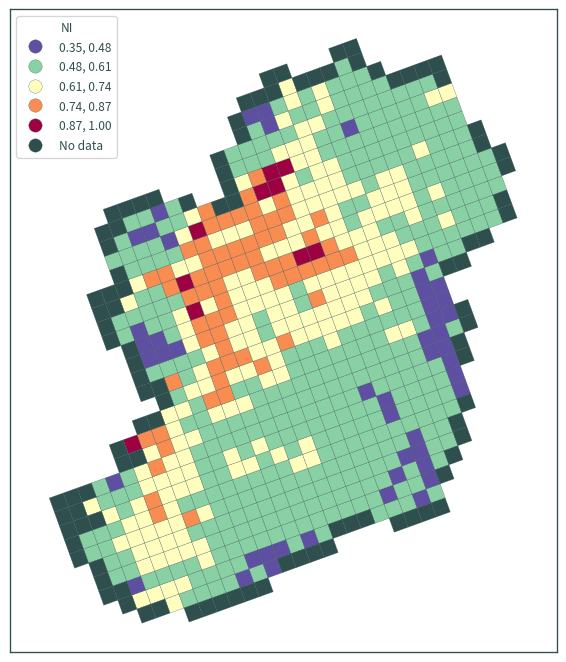

In [37]:
axs = grid_cells.plot(
    column="ni",
    cmap="Spectral_r",
    scheme="equal_interval",
    edgecolor="darkslategrey",
    linewidth=0.2,
    figsize=(6, 7),
    legend=True,
    legend_kwds={"loc": "upper left", "fmt": "{:.2f}", "title": "NNI"},
    missing_kwds={
        "color": "darkslategrey",
        "edgecolor": "darkslategrey",
        "label": "No data",
    },
)
for legend_handle in axs.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(0.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [38]:
# fill no data with min value
grid_cells["ni"] = grid_cells["ni"].fillna(grid_cells["ni"].min())

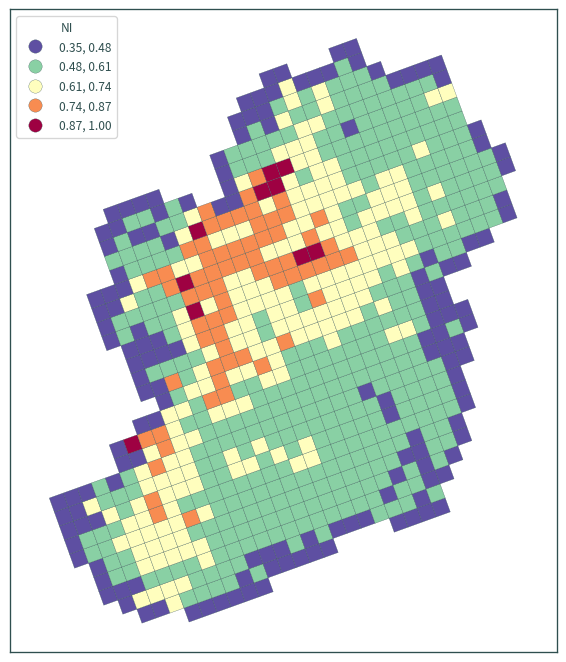

In [39]:
axs = grid_cells.plot(
    column="ni",
    cmap="Spectral_r",
    scheme="equal_interval",
    edgecolor="darkslategrey",
    linewidth=0.2,
    figsize=(6, 7),
    legend=True,
    legend_kwds={"loc": "upper left", "fmt": "{:.2f}", "title": "NNI"},
    missing_kwds={
        "color": "darkslategrey",
        "edgecolor": "darkslategrey",
        "label": "No data",
    },
)
for legend_handle in axs.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(0.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [40]:
grid_cells.drop(columns=["mean", "count"], inplace=True)

In [41]:
grid_cells.to_file(
    os.path.join("data", "ModVege", "params.gpkg"), layer="eurocordex"
)